## Model training
This notebook contains pipeline for model training

In [1]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import random
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, Callback
from torch.utils.tensorboard import SummaryWriter
import time

In [ ]:
# defining the directories for images and masks (labels) to be used for the model training
image_directory_muc = 'path/to/muc_2018/tiles'
mask_directory_muc = 'path/to/muc_2018/masks'

image_directory_ber = 'path/to/ber_2018/tiles'
mask_directory_ber = 'path/to/ber_2018/masks'

image_directory_ham = 'path/to/ham_2018/tiles'
mask_directory_ham = 'path/to/ham_2018/masks'

image_directory_dor = 'path/to/dor_2018/tiles'
mask_directory_dor = 'path/to/dor_2018/masks'

print("Muc:", len(os.listdir(image_directory_muc)))
print("Muc masks:", len(os.listdir(mask_directory_muc)))
print("Ber:", len(os.listdir(image_directory_ber)))
print("Ber masks:", len(os.listdir(mask_directory_ber)))
print("Ham:", len(os.listdir(image_directory_ham)))
print("Ham masks:", len(os.listdir(mask_directory_ham)))
print("Dor:", len(os.listdir(image_directory_dor)))
print("Dor masks:", len(os.listdir(mask_directory_dor)))

Muc: 2520
Muc masks: 2520
Ber: 1520
Ber masks: 1520
Ham: 576
Ham masks: 576
Dor: 490
Dor masks: 490


**Hyperparameters**

In [ ]:
# setting the hyperparameters
hparams = {
    'in_channels': 12,
    'out_channels': 1,
    'features': [64, 128, 256, 512],
    'learning_rate': 1e-4,
    'batch_size': 16,
    'epochs': 30,
    'dropout_prob': 0.5,
}

**Dataloader**

In [ ]:
# Loading parameters
BATCH_SIZE = hparams["batch_size"]
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = hparams["in_channels"]
TEST_SIZE = 0.2
VAL_SIZE = 0.1

In [ ]:
# Defining the dataloader

class SegmentationDataset(Dataset):
    def __init__(self, image_filenames, mask_filenames, img_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.img_size = img_size
        self.num_masks = len(self.mask_filenames)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        with rasterio.open(img_path) as src:
            img = src.read(
                out_shape=(
                    src.count,
                    self.img_size[0],
                    self.img_size[1]
                ),
                resampling=rasterio.enums.Resampling.bilinear
            )
            img = np.transpose(img, (1, 2, 0))  # reordering the dimensions to (height, width, channels)

        mask_index = idx % self.num_masks
        mask_path = self.mask_filenames[mask_index]
        with rasterio.open(mask_path) as src:
            mask = src.read(
                out_shape=(
                    src.count,
                    self.img_size[0],
                    self.img_size[1]
                ),
                resampling=rasterio.enums.Resampling.bilinear
            )
            mask = np.transpose(mask, (1, 2, 0))  # reordering the dimensions to (height, width, channels)

        mask[mask > 0] = 1  # normalizing the masks
        mask = mask[:, :, :1]  # keeping only the first channel

        img = np.transpose(img, (2, 0, 1))  
        mask = np.transpose(mask, (2, 0, 1))  
        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


# paths to the directories
image_dirs = [
    image_directory_muc,
    image_directory_ber,
    image_directory_ham,
    image_directory_dor
]

mask_dirs = [
    mask_directory_muc,
    mask_directory_ber,
    mask_directory_ham,
    mask_directory_dor
]

# collecting all image and mask file paths
image_filenames = []
mask_filenames = []

for image_dir, mask_dir in zip(image_dirs, mask_dirs):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    image_filenames.extend([os.path.join(image_dir, img) for img in image_files])
    mask_filenames.extend([os.path.join(mask_dir, msk) for msk in mask_files])


# splitting the dataset
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=TEST_SIZE + VAL_SIZE, random_state=42
)
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.25, random_state=42
)

# creating the dataset instances for train, val and test
train_dataset = SegmentationDataset(train_images, train_masks, img_size=(IMG_HEIGHT, IMG_WIDTH))
val_dataset = SegmentationDataset(val_images, val_masks, img_size=(IMG_HEIGHT, IMG_WIDTH))
test_dataset = SegmentationDataset(test_images, test_masks, img_size=(IMG_HEIGHT, IMG_WIDTH))

# creating the dataloader instances
# num_workers is set to 0, otherwise the training fails at sanity check
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Img shape: (128, 128, 12)
Mask shape: (128, 128, 1)


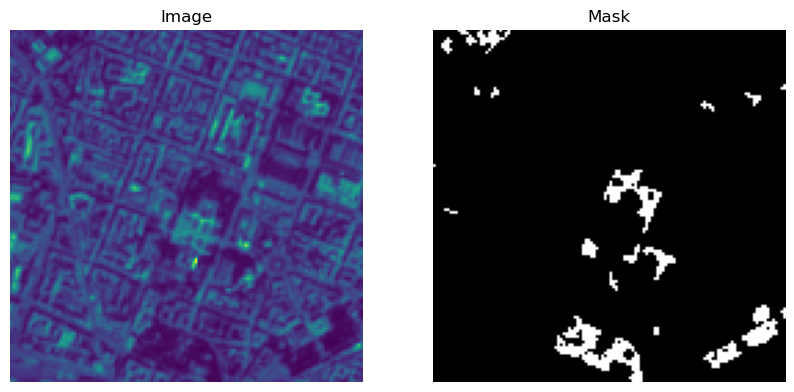

Img shape: (128, 128, 12)
Mask shape: (128, 128, 1)


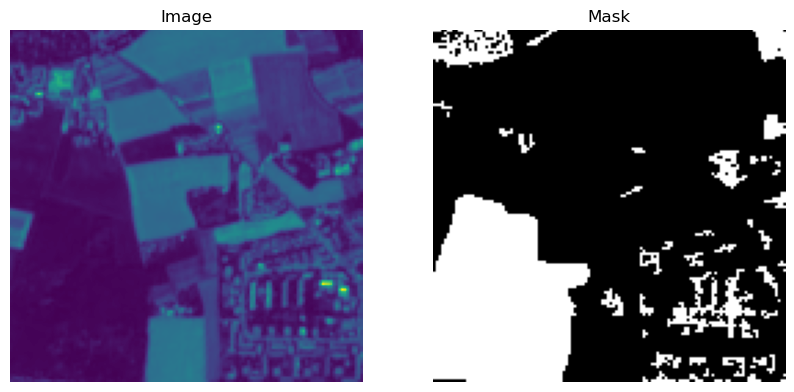

Img shape: (128, 128, 12)
Mask shape: (128, 128, 1)


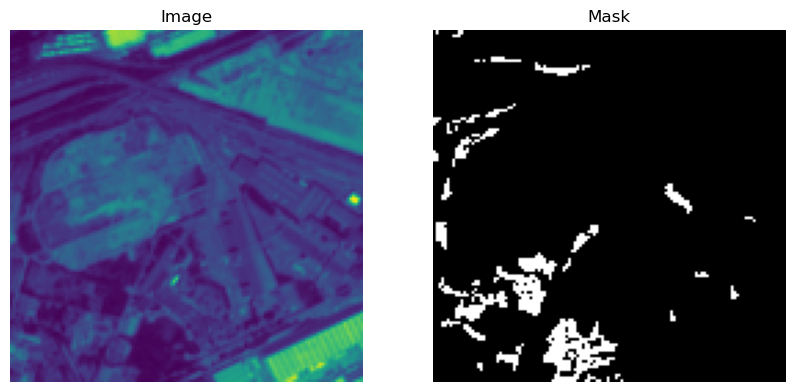

In [7]:
# Function to plot random samples from DataLoader
def plot_random_samples_from_loader(dataloader, num_samples=3):
    indices = random.sample(range(len(dataloader.dataset)), num_samples)
    
    for idx in indices:
        img, mask = dataloader.dataset[idx]
        img = img.permute(1, 2, 0).numpy()  # Convert to (height, width, channels)
        mask = mask.permute(1, 2, 0).numpy()  # Convert to (height, width, channels)
        print("Img shape:", img.shape)
        print("Mask shape:", mask.shape)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img[:, :, 3])
        ax[0].set_title("Image")
        ax[0].axis("off")

        ax[1].imshow(mask[:, :, 0], cmap='gray')
        ax[1].set_title("Mask")
        ax[1].axis("off")

        plt.show()


plot_random_samples_from_loader(train_loader)

**Defining the metrics**

In [8]:
def calculate_iou(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = (preds + masks).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def calculate_accuracy(preds, masks, threshold=0.5):
    preds = (preds > threshold).float()
    correct = (preds == masks).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

**Defining the model**

In [ ]:
# UNet 
class UNet(pl.LightningModule):
    def __init__(self, in_channels=12, out_channels=1, features=[64, 128, 256, 512], learning_rate=1e-4):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.decoder = nn.ModuleList()
        self.conv_final = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.learning_rate = learning_rate
        
        for feature in features:
            self.encoder.append(self._double_conv(in_channels, feature))
            in_channels = feature
        
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._double_conv(feature*2, feature))
        
        self.bottleneck = self._double_conv(features[-1], features[-1]*2)
        
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](concat_skip)
        
        return self.conv_final(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.learning_rate)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        self.log("train_loss", loss)

        iou = calculate_iou(preds, masks)
        accuracy = calculate_accuracy(preds, masks)
        self.log("train_iou", iou, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        self.log("val_loss", loss)

        iou = calculate_iou(preds, masks)
        accuracy = calculate_accuracy(preds, masks)

        self.log("val_iou", iou, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

        return {"val_loss": loss}
    

**Other loggers**

In [10]:
# custom epoch time logger

class EpochTimeLogger(Callback):
    def __init__(self, logger):
        super().__init__()
        self.logger = logger

    def on_train_epoch_start(self, trainer, pl_module):
        self.start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_time = time.time() - self.start_time
        self.logger.experiment.add_scalar('EpochTime', epoch_time, global_step=trainer.current_epoch)
        print(f"Epoch {trainer.current_epoch} processing time: {epoch_time:.2f} seconds")

**Connecting Tensorboard**

In [ ]:
# initializing the TensorBoard logger
logger = TensorBoardLogger("tb_logs", name="unet")

checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    dirpath='checkpoints/',
    filename='unet-{epoch:02d}-{train_loss:.2f}',
    save_top_k=3,
    mode='min',
)

# callbacks for model checkpointing and learning rate monitoring
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# custom callback for logging epoch processing time
epoch_time_logger = EpochTimeLogger(logger)


**Training**

In [ ]:
# instantiating the model
model = UNet(in_channels=hparams['in_channels'], out_channels=hparams['out_channels'], features=hparams['features'], learning_rate=hparams['learning_rate'], dropout_prob=hparams['dropout_prob'])

# instantiating the trainer
trainer = Trainer(max_epochs=hparams['epochs'], logger=logger, callbacks=[checkpoint_callback, lr_monitor, epoch_time_logger])

# logging hyperparameters
logger.log_hyperparams(hparams)

# launching the training
trainer.fit(model, train_loader, val_loader)


**Saving the model**

In [ ]:
model_name = "path/model_name.pth"
torch.save(model.state_dict(), model_name)

**Calculating additional metrics**

In [ ]:
def calculate_iou_val(preds, masks):
    #preds = (preds > threshold).float()
    intersection = (preds * masks).sum()
    union = (preds + masks).sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()
    
def calculate_overall_accuracy(preds, masks):
    correct = np.sum(preds == masks)
    total = np.prod(masks.shape)
    return correct / total

def calculate_producers_accuracy(conf_matrix):
    # (tp / (tp + fp))
    tp = conf_matrix[0, 0]
    fp = conf_matrix[1, 0]
    p_acc = tp / (tp + fp)
    return p_acc

def calculate_users_accuracy(conf_matrix):
    # (tp / (tp + fn))
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    u_acc = tp / (tp + fn)
    return u_acc

def calculate_kappa(conf_matrix):
    total = np.sum(conf_matrix)
    sum_po = np.sum(np.diag(conf_matrix))
    sum_pe = np.sum(np.sum(conf_matrix, axis=0) * np.sum(conf_matrix, axis=1)) / total
    po = sum_po / total
    pe = sum_pe / total
    kappa = (po - pe) / (1 - pe)
    return kappa

def calculate_metrics(preds, masks):
    preds = preds.flatten()
    masks = masks.flatten()

    overall_accuracy = calculate_overall_accuracy(preds, masks)
    
    conf_matrix = confusion_matrix(masks, preds) #scikit function
    producers_accuracy = calculate_producers_accuracy(conf_matrix)
    users_accuracy = calculate_users_accuracy(conf_matrix)
    kappa = calculate_kappa(conf_matrix)

    iou_val = calculate_iou_val(preds, masks)
    
    return overall_accuracy, producers_accuracy, users_accuracy, kappa, iou_val

In [ ]:
def evaluate_model_with_metrics(model, dataloader, device='cuda'):
    model.eval()  # setting model to evaluation mode
    
    all_preds = []
    all_masks = []
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            imgs, masks = batch
            imgs, masks = imgs.to(device), masks.to(device)
            
            # gettting the predictions
            preds = model(imgs)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()  # binarizing the predictions

            # converting predictions and masks to numpy arrays
            preds = preds.float().cpu().numpy()
            masks = masks.cpu().numpy()

            all_preds.append(preds)
            all_masks.append(masks)
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    
    overall_accuracy, producers_accuracy, users_accuracy, kappa, iou_val = calculate_metrics(all_preds, all_masks)
    
    return overall_accuracy, producers_accuracy, users_accuracy, kappa, iou_val

In [ ]:
# setting the model for evaluation
model.eval()
model.to('cuda')

In [ ]:
# defining the evaluation dataset and DataLoader
evaluation_dataset = DataLoader(test_dataset, batch_size=1, shuffle=False)

# evaluating the model and calculating metrics
overall_accuracy, producers_accuracy, users_accuracy, kappa, iou_val = evaluate_model_with_metrics(model, evaluation_dataset) 

# Calculating accuracy and IoU on val dataset
print(f"IoU:{iou_val:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Producer's Accuracy: {producers_accuracy:.4f}")
print(f"User's Accuracy: {users_accuracy:.4f}")
print(f"Kappa Coefficient: {kappa:.4f}")

**Plotting predictions**

In [ ]:
def plot_predictions(model, dataloader, num_samples=3, device='cuda'):
    model.eval()  
    samples = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, masks = batch
            images, masks = images.to(device), masks.to(device)

            # getting predictions
            preds = model(images)
            preds = torch.sigmoid(preds) 
            preds = (preds > 0.5).float()  

            for j in range(len(images)):
                if samples >= num_samples:
                    break

                image = images[j].cpu().numpy().transpose((1, 2, 0))  # converting to (H, W, C)
                mask = masks[j].cpu().numpy().transpose((1, 2, 0))  # converting to (H, W, C)
                pred = preds[j].cpu().numpy().transpose((1, 2, 0))  # converting to (H, W, C)

                axes[samples, 0].imshow(image[:, :, 2], cmap='gray')
                axes[samples, 0].set_title('Image')
                axes[samples, 0].axis('off')

                axes[samples, 1].imshow(mask[:, :, 0], cmap='gray')
                axes[samples, 1].set_title('Ground Truth')
                axes[samples, 1].axis('off')

                axes[samples, 2].imshow(pred[:, :, 0], cmap='gray')
                axes[samples, 2].set_title('Prediction')
                axes[samples, 2].axis('off')

                samples += 1

            if samples >= num_samples:
                break

    plt.tight_layout()
    plt.show()

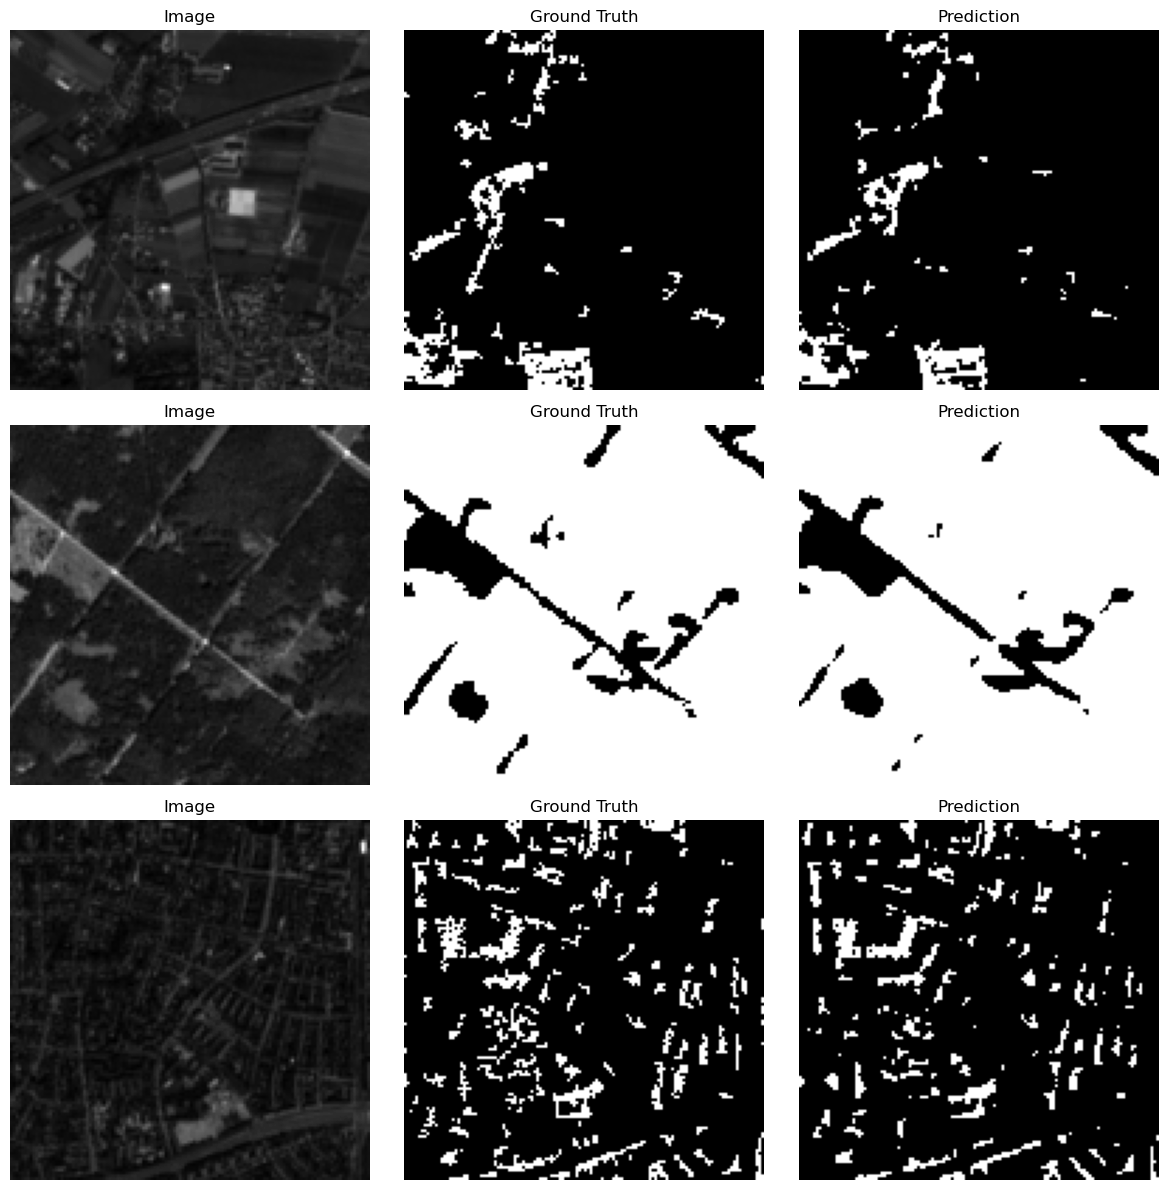

In [ ]:
# DataLoader instantiation
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) 

# plotting predictions
plot_predictions(model, test_loader, num_samples=3, device='cuda')
